In [5]:
import numpy as np
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
# cosamp function is available at https://github.com/avirmaux/CoSaMP

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [7]:
## Generate signal, DCT of signal

n = 8192 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 500 * np.pi * t) + np.cos(2 * 900 * np.pi * t) +  np.cos(2 * 700 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [4]:
## Randomly sample signal
p = 512 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

np.floor(np.random.rand(p) * n) 

Psi = dct(np.identity(n)) # Build Psi

Psi

array([[ 2.00000000e+00,  1.99999996e+00,  1.99999985e+00, ...,
         1.15048553e-03,  7.66990375e-04,  3.83495195e-04],
       [ 2.00000000e+00,  1.99999967e+00,  1.99999868e+00, ...,
        -3.45145506e-03, -2.30097067e-03, -1.15048553e-03],
       [ 2.00000000e+00,  1.99999908e+00,  1.99999632e+00, ...,
         5.75242002e-03,  3.83494962e-03,  1.91747569e-03],
       ...,
       [ 2.00000000e+00, -1.99999908e+00,  1.99999632e+00, ...,
        -5.75242002e-03,  3.83494962e-03, -1.91747569e-03],
       [ 2.00000000e+00, -1.99999967e+00,  1.99999868e+00, ...,
         3.45145506e-03, -2.30097067e-03,  1.15048553e-03],
       [ 2.00000000e+00, -1.99999996e+00,  1.99999985e+00, ...,
        -1.15048553e-03,  7.66990375e-04, -3.83495195e-04]],
      shape=(8192, 8192))

In [8]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

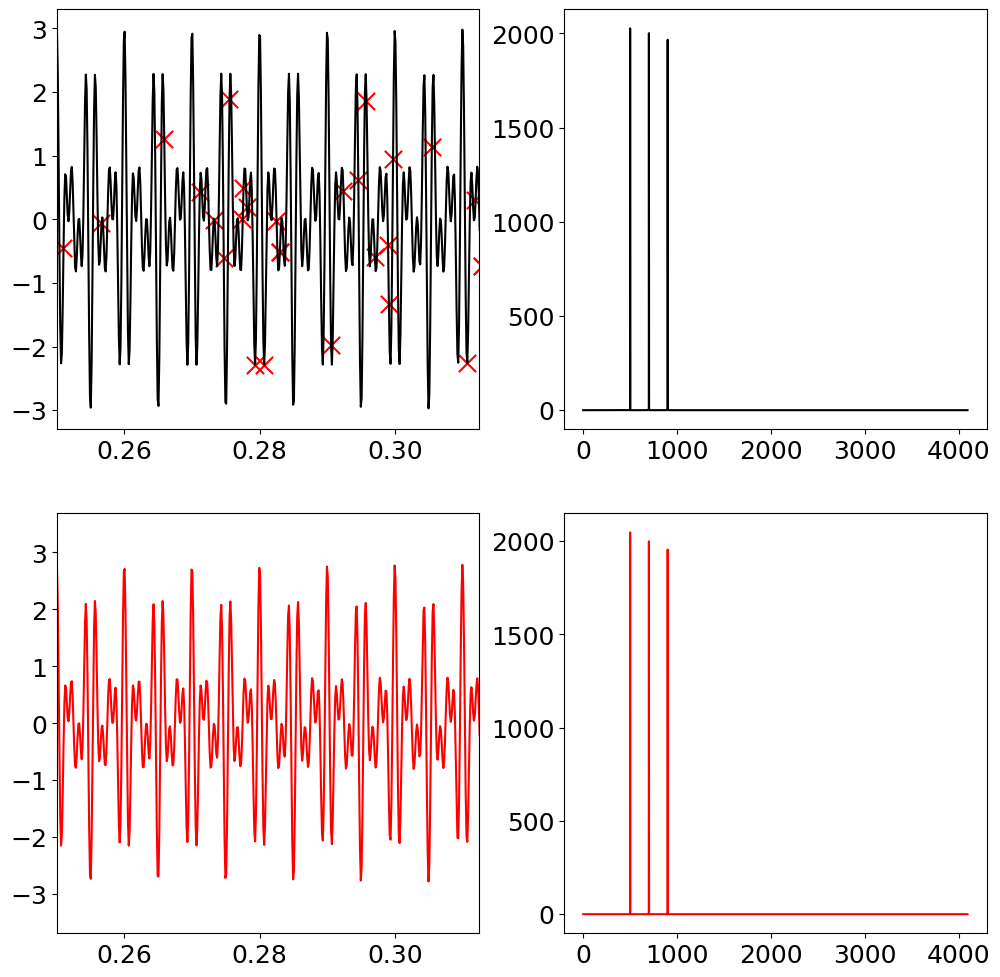

((512,), (8192,), (512,))

In [16]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k')
# axs[1].set_xlim(0, 1024)
# axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k')
axs[0].scatter(perm/n,y,color='r',marker='x',s=155)
axs[0].set_xlim(time_window[0],time_window[1])
# axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r')
axs[2].set_xlim(time_window[0],time_window[1])
# axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r')
# axs[3].set_xlim(0, 1024)
# axs[3].set_ylim(0, 1200)

plt.show()

y.shape, x.shape, (perm/n).shape

In [ ]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [ ]:
Theta.shape

In [ ]:
y.shape

In [ ]:
xrecon = idct(s) # reconstruct full signal
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k')
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k')
axs[0].scatter(perm/n,y,color='r',marker='x',s=155)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r')
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r')
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()